## Bike sharing dataset preprocessing

We will use the bike sharing dataset. The goal is to predict the number of bike
rentals using weather and season data as well as the datetime information.



In [1]:
from sklearn.datasets import fetch_openml

bikes = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True, parser="pandas")
# Make an explicit copy to avoid "SettingWithCopyWarning" from pandas
X, y = bikes.data.copy(), bikes.target

# We use only a subset of the data to speed up the example.
X = X.iloc[::5, :]
y = y[::5]

In [2]:
X["weather"].value_counts()

clear         2284
misty          904
rain           287
heavy_rain       1
Name: weather, dtype: int64

In [3]:
X["weather"].replace(to_replace="heavy_rain", value="rain", inplace=True)

In [4]:
X["year"].value_counts()

1    1747
0    1729
Name: year, dtype: int64

In [5]:
mask_training = X["year"] == 0.0
X = X.drop(columns=["year"])
X_train, y_train = X[mask_training], y[mask_training]
X_test, y_test = X[~mask_training], y[~mask_training]

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1729 entries, 0 to 8640
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      1729 non-null   category
 1   month       1729 non-null   int64   
 2   hour        1729 non-null   int64   
 3   holiday     1729 non-null   category
 4   weekday     1729 non-null   int64   
 5   workingday  1729 non-null   category
 6   weather     1729 non-null   category
 7   temp        1729 non-null   float64 
 8   feel_temp   1729 non-null   float64 
 9   humidity    1729 non-null   float64 
 10  windspeed   1729 non-null   float64 
dtypes: category(4), float64(4), int64(3)
memory usage: 115.4 KB


In [7]:
numerical_features = [
    "temp",
    "feel_temp",
    "humidity",
    "windspeed",
]
categorical_features = X_train.columns.drop(numerical_features)

In [ ]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np

days = ("Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat")
hours = tuple(range(24))
xticklabels = [f"{day}\n{hour}:00" for day, hour in product(days, hours)]
xtick_start, xtick_period = 6, 12

fig, axs = plt.subplots(nrows=2, figsize=(8, 6), sharey=True, sharex=True)
average_bike_rentals = bikes.frame.groupby(["year", "season", "weekday", "hour"]).mean(
    numeric_only=True
)["count"]
for ax, (idx, df) in zip(axs, average_bike_rentals.groupby("year")):
    df.groupby("season").plot(ax=ax, legend=True)

    # decorate the plot
    ax.set_xticks(
        np.linspace(
            start=xtick_start,
            stop=len(xticklabels),
            num=len(xticklabels) // xtick_period,
        )
    )
    ax.set_xticklabels(xticklabels[xtick_start::xtick_period])
    ax.set_xlabel("")
    ax.set_ylabel("Average number of bike rentals")
    ax.set_title(
        f"Bike rental for {'2010 (train set)' if idx == 0.0 else '2011 (test set)'}"
    )
    ax.set_ylim(0, 1_000)
    ax.set_xlim(0, len(xticklabels))
    ax.legend(loc=2)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer

mlp_preprocessor = ColumnTransformer(
    transformers=[
        ("num", QuantileTransformer(n_quantiles=100), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)
mlp_preprocessor

### Preprocessor for the gradient boosting model

For the gradient boosting model, we leave the numerical features as-is and only
encode the categorical features using a
:class:`~sklearn.preprocessing.OrdinalEncoder`.



In [ ]:
from sklearn.preprocessing import OrdinalEncoder

hgbdt_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(), categorical_features),
        ("num", "passthrough", numerical_features),
    ],
    sparse_threshold=1,
    verbose_feature_names_out=False,
).set_output(transform="pandas")
hgbdt_preprocessor

## 1-way partial dependence with different models

In this section, we will compute 1-way partial dependence with two different
machine-learning models: (i) a multi-layer perceptron and (ii) a
gradient-boosting model. With these two models, we illustrate how to compute and
interpret both partial dependence plot (PDP) for both numerical and categorical
features and individual conditional expectation (ICE).

### Multi-layer perceptron

Let's fit a :class:`~sklearn.neural_network.MLPRegressor` and compute
single-variable partial dependence plots.



In [11]:
from time import time

from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline

print("Training MLPRegressor...")
tic = time()
mlp_model = make_pipeline(
    mlp_preprocessor,
    MLPRegressor(
        hidden_layer_sizes=(30, 15),
        learning_rate_init=0.01,
        early_stopping=True,
        random_state=0,
    ),
)
mlp_model.fit(X_train, y_train)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {mlp_model.score(X_test, y_test):.2f}")

Training MLPRegressor...
done in 0.721s
Test R2 score: 0.61


Computing partial dependence plots...
done in 1.896s


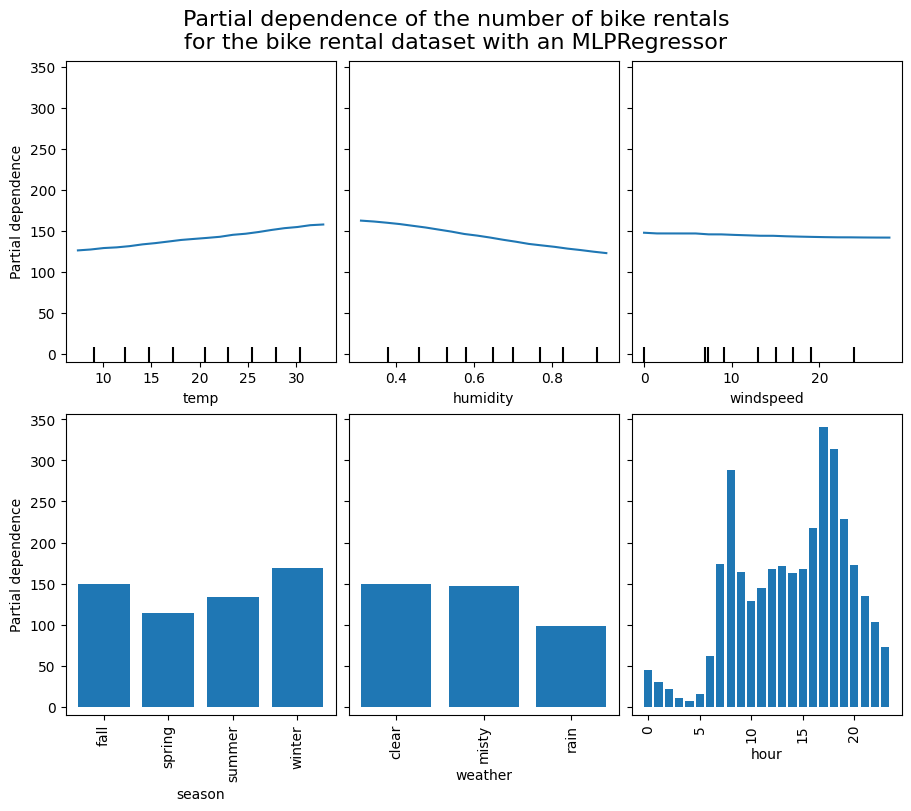

In [12]:
import matplotlib.pyplot as plt

from sklearn.inspection import PartialDependenceDisplay

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

print("Computing partial dependence plots...")
features_info = {
    # features of interest
    "features": ["temp", "humidity", "windspeed", "season", "weather", "hour"],
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    "categorical_features": categorical_features,
}
tic = time()
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    mlp_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    (
        "Partial dependence of the number of bike rentals\n"
        "for the bike rental dataset with an MLPRegressor"
    ),
    fontsize=16,
)

### Gradient boosting

Let's now fit a :class:`~sklearn.ensemble.HistGradientBoostingRegressor` and
compute the partial dependence on the same features. We also use the
specific preprocessor we created for this model.



In [13]:
from sklearn.ensemble import HistGradientBoostingRegressor

print("Training HistGradientBoostingRegressor...")
tic = time()
hgbdt_model = make_pipeline(
    hgbdt_preprocessor,
    HistGradientBoostingRegressor(
        categorical_features=categorical_features,
        random_state=0,
        max_iter=50,
    ),
)
hgbdt_model.fit(X_train, y_train)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {hgbdt_model.score(X_test, y_test):.2f}")

Training HistGradientBoostingRegressor...
done in 0.165s
Test R2 score: 0.62


Computing partial dependence plots...
done in 1.567s


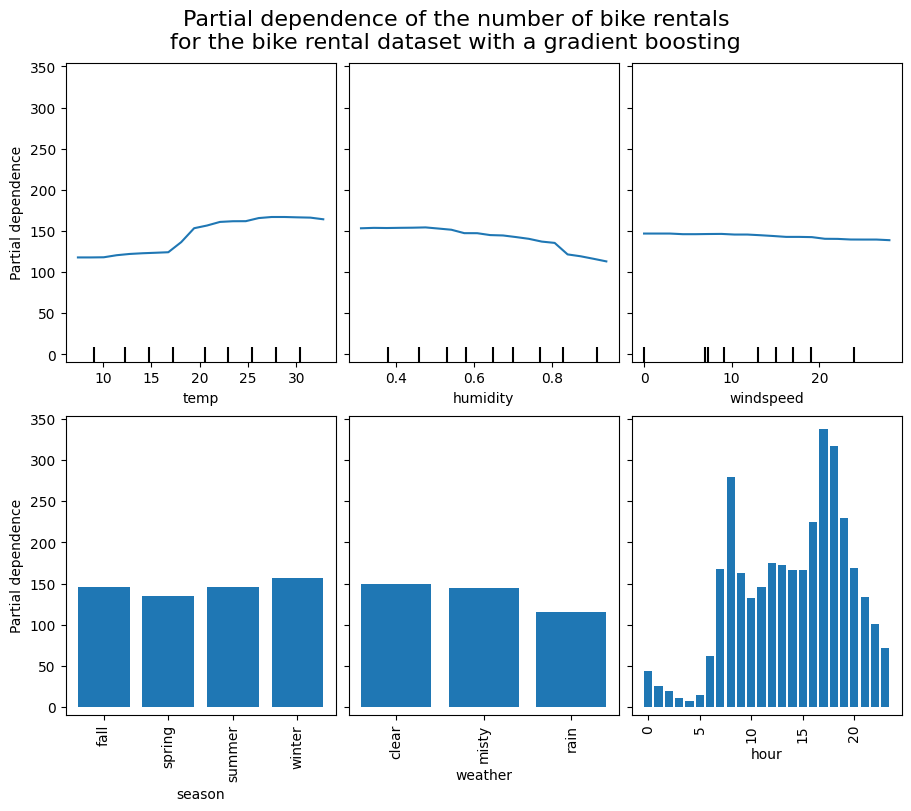

In [14]:
print("Computing partial dependence plots...")
tic = time()
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    (
        "Partial dependence of the number of bike rentals\n"
        "for the bike rental dataset with a gradient boosting"
    ),
    fontsize=16,
)

## 2D interaction plots

PDPs with two features of interest enable us to visualize interactions among them.
However, ICEs cannot be plotted in an easy manner and thus interpreted. We will show
the representation of available in
:meth:`~sklearn.inspection.PartialDependenceDisplay.from_estimator` that is a 2D
heatmap.



Computing partial dependence plots...
done in 10.296s


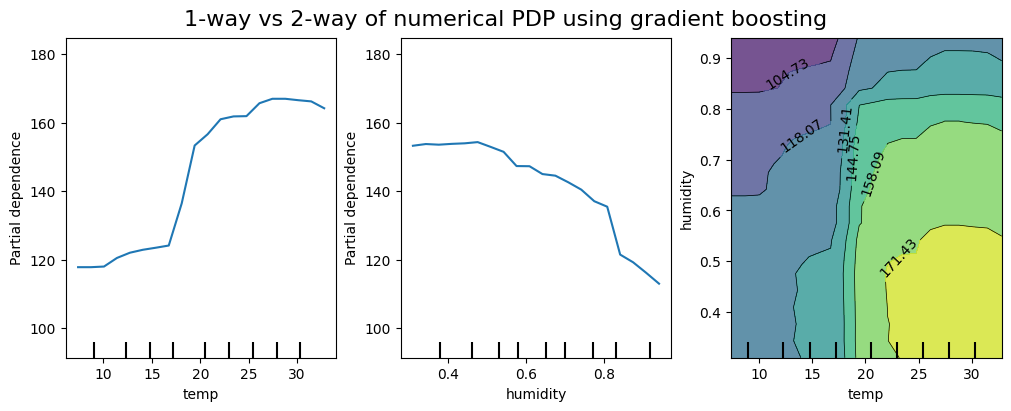

In [16]:
print("Computing partial dependence plots...")
features_info = {
    "features": ["temp", "humidity", ("temp", "humidity")],
    "kind": "average",
}
_, ax = plt.subplots(ncols=3, figsize=(10, 4), constrained_layout=True)
tic = time()
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    "1-way vs 2-way of numerical PDP using gradient boosting", fontsize=16
)